In [1]:
import os
import pandas as pd
import numpy as np

# CSV 폴더 경로
csv_dir = "/home/avees/tee/output"

# 라벨별로 값 누적
label_data = {}

# 폴더 내 CSV 파일들 읽기
csv_files = [f for f in os.listdir(csv_dir) if f.endswith(".csv")]

for filename in sorted(csv_files):
    file_path = os.path.join(csv_dir, filename)
    try:
        df = pd.read_csv(file_path)
        for col in df.columns:
            values = df[col].dropna().astype(float).tolist()
            if not values:
                continue
            if col not in label_data:
                label_data[col] = []
            label_data[col].extend(values)
    except Exception as e:
        print(f"⚠️ {filename} 읽기 실패: {e}")

# 라벨별 통계 계산
summary_rows = []
for label, values in label_data.items():
    sorted_vals = sorted(values, reverse=True)
    max_val = sorted_vals[0]
    max2_val = sorted_vals[4] if len(sorted_vals) > 4 else np.nan
    min_val = sorted_vals[-1]
    mean_val = np.nan
    if len(sorted_vals) > 1:
        mean_val = np.mean(sorted_vals[5:])  # 최대값 제외 평균

    summary_rows.append({
        "label": label,
        "count": len(values),
        "max": max_val,
        "max5": max2_val,
        "min": min_val,
        "mean(exclude_max)": mean_val
    })

# DataFrame으로 변환 및 저장
summary_df = pd.DataFrame(summary_rows)
summary_df = summary_df.sort_values(by="label")

output_path = os.path.join(csv_dir, "output_merged.csv")
summary_df.to_csv(output_path, index=False)

print(f"\n✅ 모든 파일 통합 라벨별 통계 완료 → {output_path}")
print(f"총 {len(summary_df)}개 라벨 계산됨")



✅ 모든 파일 통합 라벨별 통계 완료 → /home/avees/tee/output/output_merged.csv
총 166개 라벨 계산됨


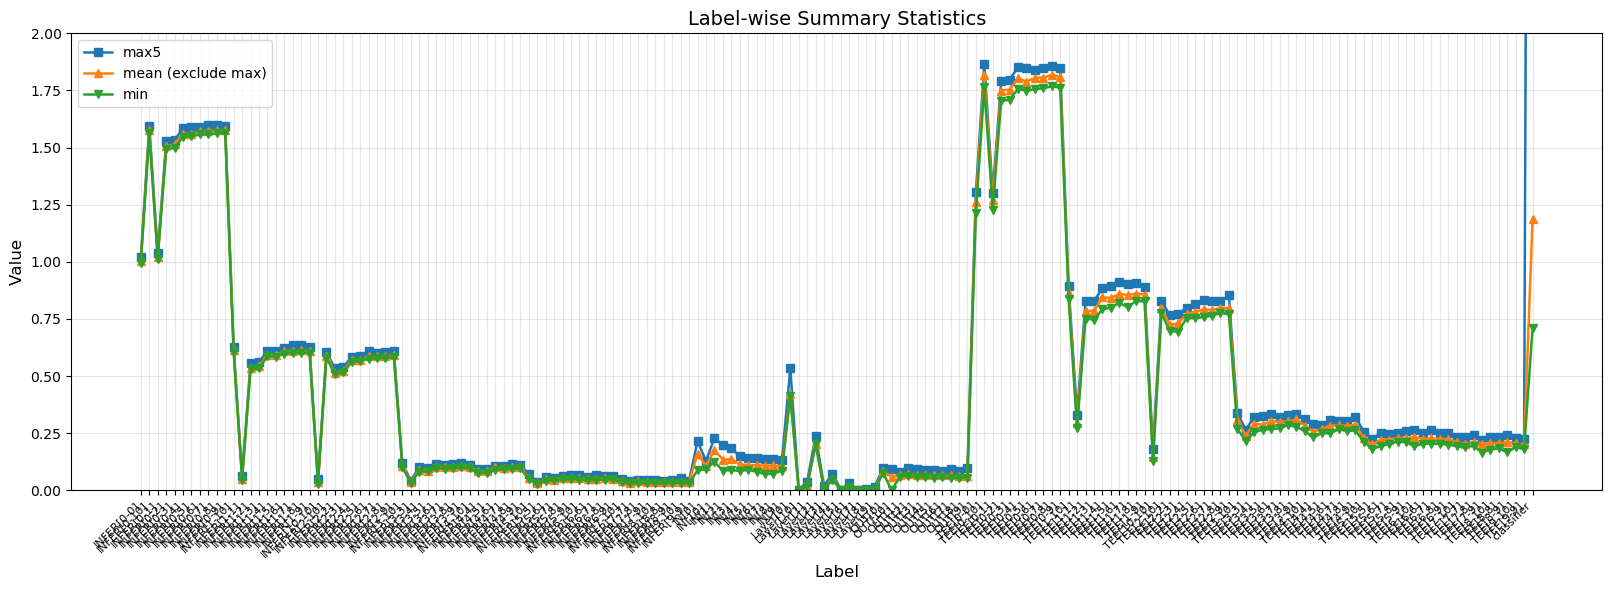

✅ 그래프 저장 완료: /home/avees/tee/output/component_with_edited/summary_plot.png


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 정리된 CSV 파일 경로
csv_path = "/home/avees/tee/output/component_with_edited/output_merged.csv"

# CSV 파일 읽기
df = pd.read_csv(csv_path)

# 컬럼 이름 통일 (mean 컬럼 이름이 괄호 때문에 처리 어려울 수 있어 수정)
df.rename(columns={"mean(exclude_max)": "mean"}, inplace=True)

# 그래프 설정
plt.figure(figsize=(16, 6))
x = np.arange(len(df["label"]))  # 라벨 개수만큼 x축 인덱스

# 각 통계값 plot
plt.plot(x, df["max5"], marker='s', label='max5', linewidth=1.8)
plt.plot(x, df["mean"], marker='^', label='mean (exclude max)', linewidth=1.8)
plt.plot(x, df["min"], marker='v', label='min', linewidth=1.8)

# 시각적 세부 설정
plt.xticks(x, df["label"], rotation=45, ha='right', fontsize=8)
plt.xlabel("Label", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.title("Label-wise Summary Statistics", fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

# 저장 및 출력
output_png = os.path.join(os.path.dirname(csv_path), "summary_plot.png")
plt.savefig(output_png, dpi=300)
plt.ylim(0, 2)
plt.show()

print(f"✅ 그래프 저장 완료: {output_png}")


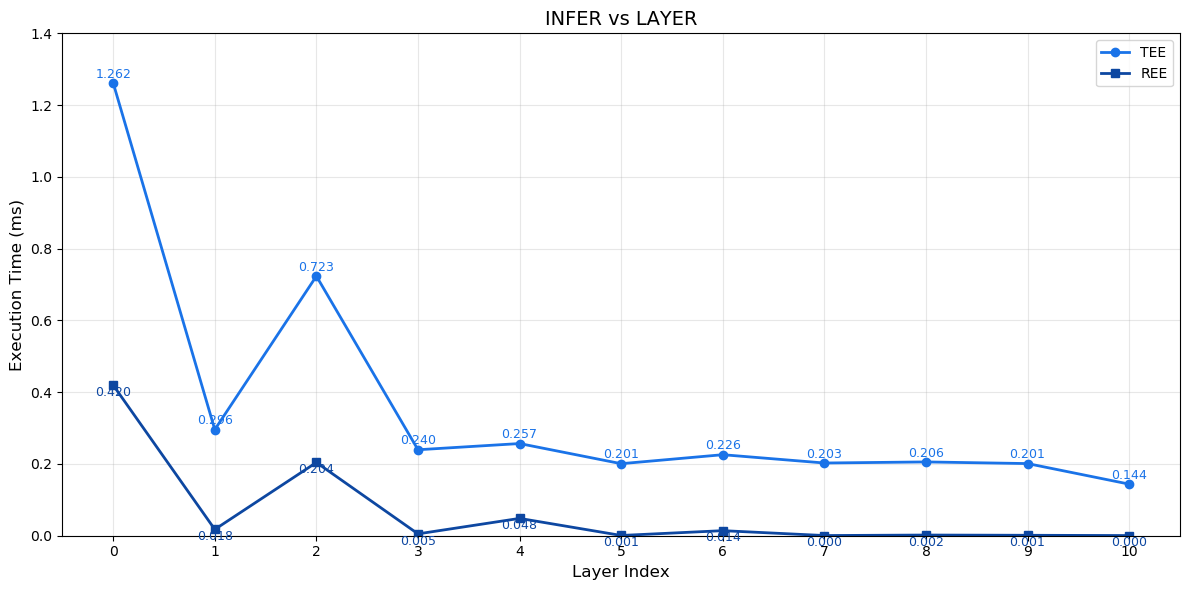

✅ 그래프 저장 완료: /home/avees/tee/output/component_with_edited/tee_layer_line_comparison.png


In [6]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# CSV 파일 경로
csv_path = "/home/avees/tee/output/component_with_edited/output_merged.csv"

# CSV 읽기
df = pd.read_csv(csv_path)
df.rename(columns={"mean(exclude_max)": "mean"}, inplace=True)

# 🔹 TEE, LAYER만 필터링 (대소문자 무시)
df = df[df["label"].str.contains("TEE|LAYER", case=False, na=False)].copy()

# 🔹 index 추출 함수
def extract_index(label):
    label = label.upper()
    # TEE[a-a] → a
    m1 = re.search(r"TEE\[(\d+)-\1\]", label)
    # LAYER[a] 또는 LAYER[a-a] → a
    m2 = re.search(r"LAYER\[(\d+)(?:-\1)?\]", label)
    if m1:
        return int(m1.group(1))
    elif m2:
        return int(m2.group(1))
    return None

df["index"] = df["label"].apply(extract_index)
df = df.dropna(subset=["index"]).copy()
df["index"] = df["index"].astype(int)

# 🔹 분리
tee_df = df[df["label"].str.contains("TEE", case=False)]
layer_df = df[df["label"].str.contains("LAYER", case=False)]

# 🔹 X축 범위 0~10
x_labels = list(range(0, 11))
x = np.arange(len(x_labels))

tee_y, layer_y = [], []

for i in x_labels:
    tee_row = tee_df[tee_df["index"] == i]
    layer_row = layer_df[layer_df["index"] == i]
    tee_val = tee_row["mean"].values[0] if not tee_row.empty else np.nan
    layer_val = layer_row["mean"].values[0] if not layer_row.empty else np.nan
    tee_y.append(tee_val)
    layer_y.append(layer_val)

# 🔹 그래프
plt.figure(figsize=(12, 6))
plt.plot(x, tee_y, marker='o', color="#1a73e8", label='TEE', linewidth=2)
plt.plot(x, layer_y, marker='s', color="#0d47a1", label='REE', linewidth=2)

# 각 점에 수치 표시
for i, (ty, ly) in enumerate(zip(tee_y, layer_y)):
    if not np.isnan(ty):
        plt.text(i, ty + 0.015, f"{ty:.3f}", color="#1a73e8", ha='center', fontsize=9)
    if not np.isnan(ly):
        plt.text(i, ly - 0.03, f"{ly:.3f}", color="#0d47a1", ha='center', fontsize=9)

# 설정
plt.xticks(x, x_labels)
plt.xlabel("Layer Index", fontsize=12)
plt.ylabel("Execution Time (ms)", fontsize=12)
plt.title("INFER vs LAYER", fontsize=14)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

# 저장
output_png = os.path.join(os.path.dirname(csv_path), "tee_layer_line_comparison.png")
plt.savefig(output_png, dpi=300)
plt.ylim(0, 1.4)
plt.show()


print(f"✅ 그래프 저장 완료: {output_png}")


✅ IN 라벨 개수: 11
✅ OUT 라벨 개수: 11


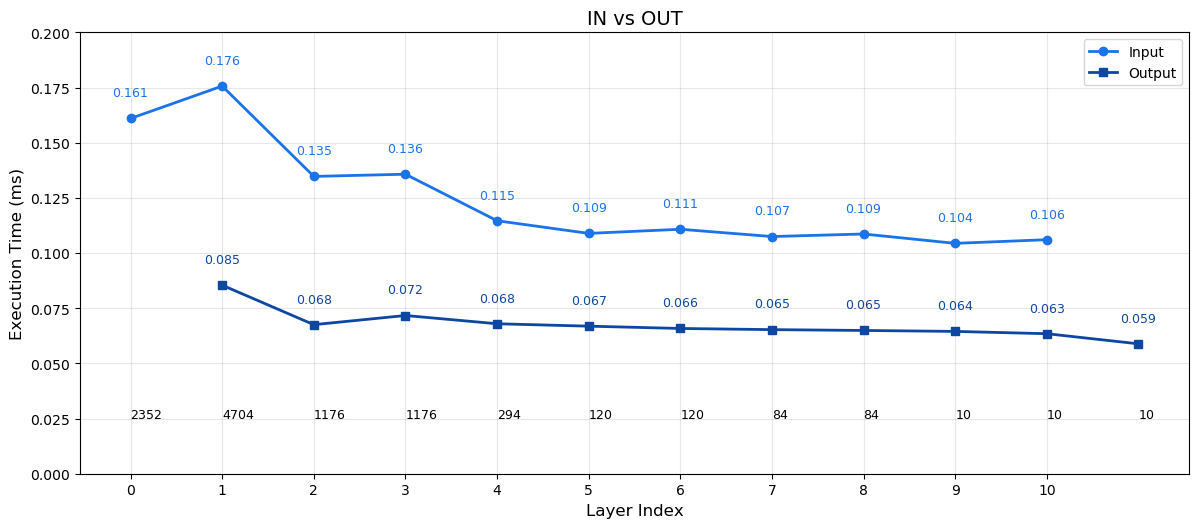

✅ 그래프 저장 완료: /home/avees/tee/output/component_with_edited/in_out_line_comparison_fixed.png


In [ ]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# CSV 파일 경로
csv_path = "/home/avees/tee/output/component_with_edited/output_merged.csv"

# CSV 읽기
df = pd.read_csv(csv_path)
df.rename(columns={"mean(exclude_max)": "mean"}, inplace=True)

# 🔹 IN, OUT만 필터링 (대소문자 무시)
df = df[df["label"].str.contains("IN|OUT", case=False, na=False)].copy()

# 🔹 index 추출 (IN[0], OUT[0] 형식)
def extract_index(label):
    label = label.upper()
    m = re.search(r"(?:IN|OUT)\[(\d+)\]", label)
    if m:
        return int(m.group(1))
    return None

df["index"] = df["label"].apply(extract_index)
df = df.dropna(subset=["index"]).copy()
df["index"] = df["index"].astype(int)

# 🔹 분리
in_df = df[df["label"].str.contains("IN", case=False)]
out_df = df[df["label"].str.contains("OUT", case=False)]

print(f"✅ IN 라벨 개수: {len(in_df)}")
print(f"✅ OUT 라벨 개수: {len(out_df)}")

# 🔹 X축 (0~10)
x_labels = sorted(set(df["index"]))
x = np.arange(len(x_labels))

in_y, out_y = [], []

for i in x_labels:
    in_row = in_df[in_df["index"] == i]
    out_row = out_df[out_df["index"] == i]
    in_val = in_row["mean"].values[0] if not in_row.empty else np.nan
    out_val = out_row["mean"].values[0] if not out_row.empty else np.nan
    in_y.append(in_val)
    out_y.append(out_val)

# 🔹 그래프
plt.figure(figsize=(12, 6))
plt.plot(x, in_y, marker='o', color="#1a73e8", label='Input', linewidth=2)
plt.plot(x+1, out_y, marker='s', color="#0d47a1", label='Output', linewidth=2)

# 🔹 점 위에 수치 표시
for i, (iy, oy) in enumerate(zip(in_y, out_y)):
    if not np.isnan(iy):
        plt.text(i, iy + 0.01, f"{iy:.3f}", color="#1a73e8", ha='center', fontsize=9)
    if not np.isnan(oy):
        plt.text(i+1, oy + 0.01, f"{oy:.3f}", color="#0d47a1", ha='center', fontsize=9)

mat_size = [28*28*3, 28*28*6, 14*14*6, 14*14*6, 7*7*6, 120, 120, 84, 84, 10, 10, 11]
for i, size in enumerate(mat_size):
    plt.text(i, 0.025, size, fontsize=9)

# 🔹 그래프 설정
plt.xticks(x, x_labels)
plt.xlabel("Layer Index", fontsize=12)
plt.ylabel("Execution Time (ms)", fontsize=12)
plt.title("IN vs OUT", fontsize=14)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.ylim(0,.2)
# 저장
output_png = os.path.join(os.path.dirname(csv_path), "in_out_line_comparison_fixed.png")
plt.savefig(output_png, dpi=300)
plt.show()

print(f"✅ 그래프 저장 완료: {output_png}")


✅ IN 라벨 개수: 11
✅ OUT 라벨 개수: 11


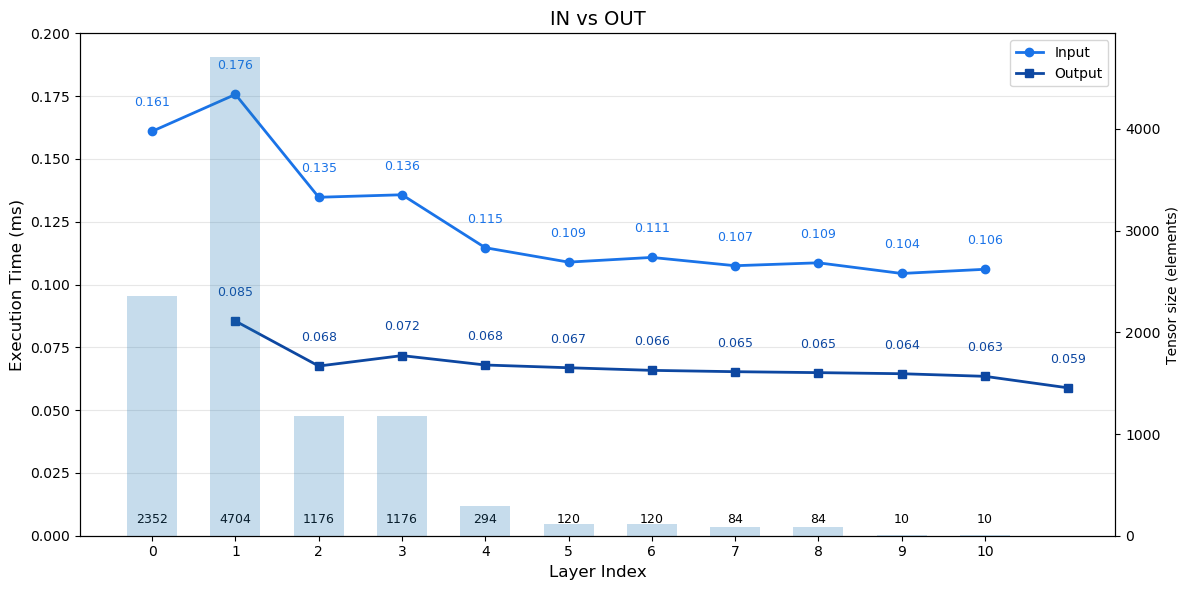

✅ 그래프 저장 완료: /home/avees/tee/output/component_with_edited/in_out_line_comparison_fixed.png


In [22]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# CSV 파일 경로
csv_path = "/home/avees/tee/output/component_with_edited/output_merged.csv"

# CSV 읽기
df = pd.read_csv(csv_path)
df.rename(columns={"mean(exclude_max)": "mean"}, inplace=True)

# 🔹 IN, OUT만 필터링 (대소문자 무시)
df = df[df["label"].str.contains("IN|OUT", case=False, na=False)].copy()

# 🔹 index 추출 (IN[0], OUT[0] 형식)
def extract_index(label):
    label = label.upper()
    m = re.search(r"(?:IN|OUT)\[(\d+)\]", label)
    if m:
        return int(m.group(1))
    return None

df["index"] = df["label"].apply(extract_index)
df = df.dropna(subset=["index"]).copy()
df["index"] = df["index"].astype(int)

# 🔹 분리
in_df = df[df["label"].str.contains("IN", case=False)]
out_df = df[df["label"].str.contains("OUT", case=False)]

print(f"✅ IN 라벨 개수: {len(in_df)}")
print(f"✅ OUT 라벨 개수: {len(out_df)}")

# 🔹 X축 (0~10)
x_labels = sorted(set(df["index"]))
x = np.arange(len(x_labels))

in_y, out_y = [], []

for i in x_labels:
    in_row = in_df[in_df["index"] == i]
    out_row = out_df[out_df["index"] == i]
    in_val = in_row["mean"].values[0] if not in_row.empty else np.nan
    out_val = out_row["mean"].values[0] if not out_row.empty else np.nan
    in_y.append(in_val)
    out_y.append(out_val)

plt.figure(figsize=(12, 6))
ax = plt.gca()

# IN / OUT 선 그래프
line_in,  = ax.plot(x,   in_y,  marker='o', color="#1a73e8", label='Input',  linewidth=2, zorder=3)
line_out, = ax.plot(x+1, out_y, marker='s', color="#0d47a1", label='Output', linewidth=2, zorder=3)

# 점 위 수치
for i, (iy, oy) in enumerate(zip(in_y, out_y)):
    if not np.isnan(iy):
        ax.text(i,   iy + 0.01, f"{iy:.3f}", color="#1a73e8", ha='center', fontsize=9)
    if not np.isnan(oy):
        ax.text(i+1, oy + 0.01, f"{oy:.3f}", color="#0d47a1", ha='center', fontsize=9)

# ===== mat_size 막대그래프(보조 y축) =====
# x 개수와 길이 맞추기
mat_size = [28*28*3, 28*28*6, 14*14*6, 14*14*6, 7*7*6, 120, 120, 84, 84, 10, 10, 1]
mat_size = mat_size[:len(x_labels)]  # 길이 초과 방지
for i, size in enumerate(mat_size):
    plt.text(i, 0.005, size, ha='center', fontsize=9)

ax2 = ax.twinx()
bars = ax2.bar(x, mat_size, width=0.6, alpha=0.25, zorder=1)  # 뒤에 깔림
ax2.set_ylabel("Tensor size (elements)")
# 필요하면 로그 스케일 사용 (데이터 크기 차이가 큰 경우 보기 쉬움)
# ax2.set_yscale('log')

# 범례 묶기
lines = [line_in, line_out]
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc='upper right')

# 축/레이블/그리드
ax.set_xticks(x); ax.set_xticklabels(x_labels)
ax.set_xlabel("Layer Index", fontsize=12)
ax.set_ylabel("Execution Time (ms)", fontsize=12)
ax.set_title("IN vs OUT", fontsize=14)
ax.grid(alpha=0.3, axis='y', zorder=0)

ax.set_ylim(0, 0.2)  # 실행시간 축 범위 유지

plt.tight_layout()

# 저장
output_png = os.path.join(os.path.dirname(csv_path), "in_out_line_comparison_fixed.png")
plt.savefig(output_png, dpi=300)
plt.show()
print(f"✅ 그래프 저장 완료: {output_png}")


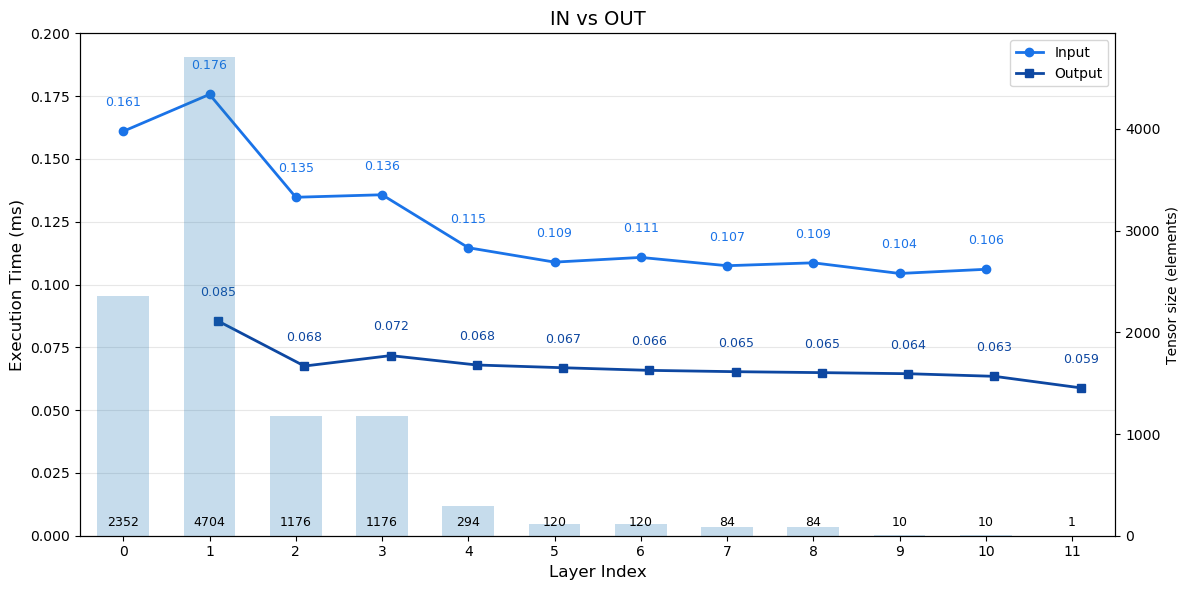

✅ 그래프 저장 완료: /home/avees/tee/output/component_with_edited/in_out_line_comparison_fixed.png


In [30]:
# ... (위 전처리는 동일)

# 🔹 x축을 0..11로 고정
MAX_IDX = 11
x_labels = list(range(0, MAX_IDX + 1))
x = np.arange(len(x_labels))  # 0..11

# 🔹 각 인덱스별 mean 매핑 후, 없으면 NaN
in_map  = dict(zip(in_df["index"],  in_df["mean"]))
out_map = dict(zip(out_df["index"], out_df["mean"]))

in_y  = [in_map.get(i,  np.nan) for i in x_labels]
out_y = [out_map.get(i, np.nan) for i in x_labels]

plt.figure(figsize=(12, 6))
ax = plt.gca()

# IN / OUT 선 그래프 (OUT은 살짝 오른쪽으로 오프셋)
out_x = x + 0.1
line_in,  = ax.plot(x,     in_y,  marker='o', color="#1a73e8", label='Input',  linewidth=2, zorder=3)
line_out, = ax.plot(out_x+1, out_y, marker='s', color="#0d47a1", label='Output', linewidth=2, zorder=3)

# 점 위 수치
for xi, xo, iy, oy in zip(x, out_x, in_y, out_y):
    if not np.isnan(iy):
        ax.text(xi, iy + 0.01, f"{iy:.3f}", color="#1a73e8", ha='center', fontsize=9)
    if not np.isnan(oy):
        ax.text(xo+1, oy + 0.01, f"{oy:.3f}", color="#0d47a1", ha='center', fontsize=9)

# ===== mat_size 막대그래프(보조 y축) =====
mat_size = [28*28*3, 28*28*6, 14*14*6, 14*14*6, 7*7*6, 120, 120, 84, 84, 10, 10, 1]
ax2 = ax.twinx()
for i, size in enumerate(mat_size):
    plt.text(i, 100, size, ha='center', fontsize=9)
ax2.bar(x, mat_size, width=0.6, alpha=0.25, zorder=1)
ax2.set_ylabel("Tensor size (elements)")
# ax2.set_yscale('log')  # 필요시

# 범례/축/그리드
ax.legend(loc='upper right')
ax.set_xticks(x); ax.set_xticklabels(x_labels)
ax.set_xlim(-0.5, MAX_IDX + 0.5)
ax.set_xlabel("Layer Index", fontsize=12)
ax.set_ylabel("Execution Time (ms)", fontsize=12)
ax.set_title("IN vs OUT", fontsize=14)
ax.grid(alpha=0.3, axis='y', zorder=0)
ax.set_ylim(0, 0.2)

plt.tight_layout()

output_png = os.path.join(os.path.dirname(csv_path), "in_out_line_comparison_fixed.png")
plt.savefig(output_png, dpi=300)
plt.show()
print(f"✅ 그래프 저장 완료: {output_png}")
